# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
import time
from datetime import timedelta
import math
import os
# TODO: fill this in based on where you saved the training and testing data
training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
del train, test

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [4]:
# print lable structure
print(y_train[0:50])
# therefore, data needs to be shuffled

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


The min value is:  168
The max value is:  1800


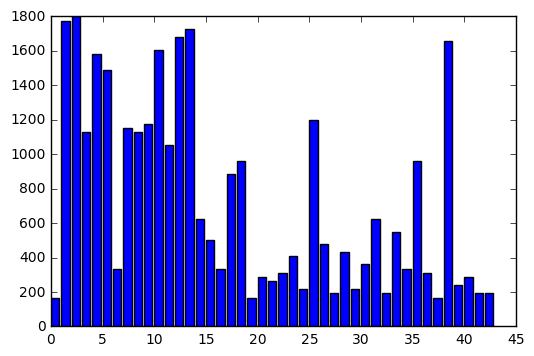

In [28]:
# each sign, how many occus in the training set
from collections import Counter
labels = Counter(y_train)
new_labels_counts = Counter({key:label for key, label in zip(labels.keys(), labels.values())})

%matplotlib inline
from matplotlib import pyplot as plt
plt.bar(list(labels.keys()), list(labels.values()))
print('The min value is: ', min(labels.values()))
print('The max value is: ', max(labels.values()))

Based on the diagram abovce, the distribution of number of same traffic sign is skewed. The prediction results may be influenced by it. Some are higher (highest is 2250), some are much lower (lowest is only 210). But 210 is still not a small number, so we can still use accuracy (But confusion matrix and F-score will surely be better evaluation matrix)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [7]:
import tensorflow as tf
X_train_yuv = tf.Variable(X_train)
X_test_yuv = tf.Variable(X_test)
del X_train, X_test

with tf.Session() as session:
    session.run(tf.initialize_all_variables())

    X_train_yuv = tf.image.rgb_to_grayscale(X_train_yuv)
    X_test_yuv = tf.image.rgb_to_grayscale(X_test_yuv)

    X_train_yuv = session.run(X_train_yuv)
    X_test_yuv = session.run(X_test_yuv)

In [8]:
# split the training set into training set and validation set
from sklearn.model_selection import train_test_split
X_train_yuv, X_valid, y_train, y_valid= train_test_split(X_train_yuv, y_train, test_size=0.2, random_state = 1327,
                                                        stratify=y_train)

In [9]:
print(X_train_yuv.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(31367, 32, 32, 1)
(7842, 32, 32, 1)
(31367,)
(7842,)


In [10]:
# make sure each labels are equally distributed in training set
from collections import Counter
aa = Counter(y_train)
bb = Counter(y_valid)
print(aa.most_common(10))
print(bb.most_common(10))

[(2, 1800), (1, 1776), (13, 1728), (12, 1680), (38, 1656), (10, 1608), (4, 1584), (5, 1488), (25, 1200), (9, 1176)]
[(2, 450), (1, 444), (13, 432), (12, 420), (38, 414), (10, 402), (4, 396), (5, 372), (25, 300), (9, 294)]


In [11]:
# shuffle them 5 times
from sklearn.utils import shuffle
for i in range(5):
    X_train_yuv, y_train = shuffle(X_train_yuv, y_train, random_state=i)
    X_valid, y_valid = shuffle(X_valid, y_valid, random_state=i)
    X_test_yuv, y_test = shuffle(X_test_yuv, y_test, random_state=i)

In [12]:
# save pre-processed images and labels for future usage.

pickle_file = 'preprocessed.p'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'X_train_yuv': X_train_yuv,
                    'X_valid': X_valid,
                    'X_test_yuv': X_test_yuv,
                    'y_train': y_train,
                    'y_valid': y_valid,
                    'y_test': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')
print(y_train.shape)
print(y_test.shape)

Data cached in pickle file.
(31367,)
(12630,)


In [13]:
del X_train_yuv, X_valid, X_test_yuv, y_train, y_valid, y_test

In [14]:
# Normalize image by using per_image_whitening, but it is extremely slow, will try to modify to speed it up
# in next version

# print("session starts")
# # todo this whitening operation is really slow. find some fast ways.

# for i in range(n_train):
#     X_train_yuv[i] = session.run(tf.image.per_image_whitening(X_train_yuv[i]))

# for j in range(n_test):
#     X_test_yuv[j] = session.run(tf.image.per_image_whitening(X_test_yuv[j]))

# print('X_train type ', type(X_train_yuv))
# print('X_test type: ', type(X_test_yuv))
# print(X_train_yuv.shape)
# print(X_test_yuv.shape) # Save the X_train_yuv for easy access

# pickle_file = 'gray_normalized.p'
# if not os.path.isfile(pickle_file):
#     print('Saving data to pickle file...')
#     try:
#         with open('gray_normalized.p', 'wb') as pfile:
#             pickle.dump(
#                 {
#                     'X_train_yuv': X_train_yuv,
#                     'X_test_yuv': X_test_yuv,
#                     'y_train': y_train,
#                     'y_test': y_test,
#                 },
#                 pfile, pickle.HIGHEST_PROTOCOL)
#     except Exception as e:
#         print('Unable to save data to', pickle_file, ':', e)
#         raise

# print('Data cached in pickle file.')
# print(y_train.shape)
# print(y_test.shape)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
- Convert to rgb image to greyscale (Based on Pierre and Yann's paper methioned above, using single Y channel in YUV colorspace just loss little information, and I think it will be more fast, I'll use YUV in its next version)
- Random shuffle for training and testing dataset to mix all samples.
- Normalization. Use per_image_whitening to normalize each grey scale image, as show in 'In [9]' cell (Not running in this notebook, it is extremely slow. I Will revise it to speed up in next version)
- Split the data into training, validation and test set, as detailed explaination in answer of question 2.
- Save all preprocessed data in disk for future usage, then no need to re-preprocessing data in the future usage. 

In [15]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

Split training dataset into training dataset and validation dataset in a stratified way(e.g. label 0 has 100 instances, make sure 80% instances of label 0 are in training set and 20 are in validation set). Use train_test_split method in sklearn.models to split the training dataset into training dataset and validation dataset. The validation size I chose is 20% of original training dataset (7841 images and its corresponding labels). The reasons are:
   - 20% does not consume too much training dataset. Original training set is not very large (39209 in total), so validation dataset cannot be too big to consume too much training data.
   - 20% of all original training set (7841 instances) is not a very small for validation, it is large enough to prevent noise and distortion in validation set. 

In [16]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [17]:
# Load pickled data
import pickle
import numpy as np
import time
from datetime import timedelta
import math
import os
import tensorflow as tf
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
# TODO: fill this in based on where you saved the training and testing data
preprocessed = './preprocessed.p'

with open(preprocessed, mode='rb') as f:
    preprocessed_data = pickle.load(f)
    
X_train_yuv, y_train = preprocessed_data['X_train_yuv'], preprocessed_data['y_train']
X_test_yuv, y_test = preprocessed_data['X_test_yuv'], preprocessed_data['y_test']
X_valid, y_valid = preprocessed_data['X_valid'], preprocessed_data['y_valid']
del preprocessed_data

In [18]:
# define imgage variables and label class size
img_num = X_train_yuv.shape[0]
img_height = X_train_yuv.shape[1]
img_width = X_train_yuv.shape[2]
num_channel = X_train_yuv.shape[3]
n_classes = len(set(y_train))

In [19]:
x = tf.placeholder(tf.float32, shape=[None, img_height, img_width, 1], name='x')
y_true = tf.placeholder(tf.int64, shape=[None], name='y_true')

# Define ConvLayer 1 filters
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Define ConvLayer 2 filters
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.
fc_size = 128             # Number of neurons in fully-connected layer.

train_batch_size = 64
test_batch_size = 256

In [20]:
# some help functions

def plot_images(images, cls_true, cls_pred=None):
    print('images length is: ', images.shape)
    print('cls_true length is: ', cls_true.shape)
    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        print('i: ', i)
        print('ax: ', ax)
        # ax.imshow(images[i], cmap='binary')
        ax.imshow(np.squeeze(images[i], axis=(2, )))
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

    
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    layer = tf.nn.relu(layer)
    return layer, weights


def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features


def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    # use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


# for plotting 
def plot_example_errors(X_compared, y_compared, cls_pred, correct):
    incorrect = (correct == False)
    images = X_compared[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = y_compared[incorrect]
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])


def plot_confusion_matrix(X_compared, y_compared, cls_pred):
    cls_true = y_compared
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
        
def print_test_accuracy(X_compared, y_compared, valid_set, show_example_errors=False, show_confusion_matrix=False):
    num_test = len(y_compared)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = X_compared[i:j]
        labels = y_compared[i:j]

        feed_dict = {x: images, y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = y_compared
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    if valid_set:
        set_name = 'Validation-Set'
    else:
        set_name = 'Test-Set'
    msg = "Accuracy on " + set_name + ": {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        print(type(correct))
        plot_example_errors(X_compared, y_compared, cls_pred, correct=correct)
        

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
    
    return acc

        
def plot_images(images, cls_true, cls_pred=None):
    print('images length is: ', images.shape)
    print('cls_true length is: ', cls_true.shape)
    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        print('i: ', i)
        print('ax: ', ax)
        # ax.imshow(images[i], cmap='binary')
        ax.imshow(np.squeeze(images[i], axis=(2, )))
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [21]:
# Conv layer 1 with filter_size 5, 16 filters used. Conv -> max pooling/subsampling -> activation by ReLu 
layer_conv1, weights_conv1 = new_conv_layer(input=x, num_input_channels=num_channel, filter_size=filter_size1,
                                            num_filters=num_filters1, use_pooling=True)

# Conv layer 2 with filter_size 5, 36 filters used. Conv -> max pooling/subsampling -> activation by ReLu 
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, 
                                            filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)

# Prepare input features for the following DNN by flat the 36@8*8*1 layer to a 1d feature vectors.  
layer_flat, num_features = flatten_layer(layer_conv2)

# Use a 128-neurals NN layer as a hidden layer to classify the 1d feature vectors, then a ReLu to give 
# non-linear property
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)

# Use a 43-neurals NN layer as a final classifier (43 label types in total)
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=n_classes, use_relu=False)

# softmax layer_fc2 to give probablity distribution
y_pred = tf.nn.softmax(layer_fc2)
# know which signal type it belongs to by converting one hot encoding to a single scalar
y_pred_cls = tf.argmax(y_pred, dimension=1)

# use entropy function to compare how far away from one hot encoding prediction for a batch-size images 
# to their real label value. 
# y_true is in 1-d shape, sparse_softmax_cross_entroy_with_logits can do auto one-hot encoding.
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

# get mean entropy difference
cost = tf.reduce_mean(cross_entropy)

# use AdamOptimizer as Optimizer to adjust parameters in all CNN layers 
# (including all weights metrices, all bias metrics) to reduce cost function.
# optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# Calculate how many prediction and real value matches in a single batch (therefore, it has only 64 values 
# possible since every train batch size is only 64 as defined below). 
correct_prediction = tf.equal(y_pred_cls, y_true) 

# get mean prediction
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()

# session.run(tf.initialize_all_variables())

In [22]:
img_train_count = X_train_yuv.shape[0]
print('img_train_count is: ', img_train_count)

img_train_count is:  31367


In [23]:

total_iterations = 0

epoch_train = np.array([], np.int32)
epoch_valid = np.array([], np.int32)

img_train_count = X_train_yuv.shape[0]
train_feed_dict = {x: X_train_yuv[:8000], y_true: y_train[:8000]}
valid_feed_dict = {x: X_valid, y_true: y_valid}

def optimize(epochs, train_batch_size):
    global X_train_yuv, y_train, train_feed_dict, epoch_train, epoch_valid
    global total_iterations
    start_time = time.time()
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
    session.run(tf.initialize_all_variables())
    
    num_iterations = math.floor(img_train_count / train_batch_size)

    for k in range(epochs):
        batch_index = np.array(range(train_batch_size))
        for i in range(total_iterations, total_iterations + num_iterations - 1):
            # x_batch, y_true_batch = data.train.next_batch(train_batch_size) # numpy array
            try:
                x_batch = X_train_yuv[batch_index]
                y_true_batch = y_train[batch_index]
                batch_index += train_batch_size
                # re-count batches from index 0
                batch_index = batch_index % img_train_count
            except IndexError:
                print('training batch out of index: ', batch_index)
            feed_dict_train = {x: x_batch, y_true: y_true_batch}
            session.run(optimizer, feed_dict=feed_dict_train)

        training_acc = session.run(accuracy, feed_dict=train_feed_dict)
        # valid_acc = session.run(accuracy, feed_dict=valid_feed_dict)
        msg = "Optimization epoch: {0:>6}, Training Accuracy: {1:>6.1%}"
        print("")
        print(msg.format(k + 1, training_acc))
        valid_acc = print_test_accuracy(X_valid, y_valid, valid_set=True)
        epoch_train = np.append(epoch_train, training_acc)
        epoch_valid = np.append(epoch_valid, valid_acc)
        
        if len(epoch_valid) > 10:
            if (epoch_valid[-10] > epoch_valid[-9:]).all():
                break
        # shuffle training set to make sure order changes.
        X_train_yuv, y_train = shuffle(X_train_yuv, y_train, random_state=k)
        total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


In [24]:
optimize(epochs=500, train_batch_size=64)



Optimization epoch:      1, Training Accuracy:  65.3%
Accuracy on Validation-Set: 64.1% (5023 / 7842)

Optimization epoch:      2, Training Accuracy:  80.9%
Accuracy on Validation-Set: 79.6% (6246 / 7842)

Optimization epoch:      3, Training Accuracy:  89.2%
Accuracy on Validation-Set: 87.2% (6841 / 7842)

Optimization epoch:      4, Training Accuracy:  92.4%
Accuracy on Validation-Set: 90.4% (7093 / 7842)

Optimization epoch:      5, Training Accuracy:  93.3%
Accuracy on Validation-Set: 91.3% (7161 / 7842)

Optimization epoch:      6, Training Accuracy:  95.6%
Accuracy on Validation-Set: 93.3% (7319 / 7842)

Optimization epoch:      7, Training Accuracy:  96.9%
Accuracy on Validation-Set: 94.4% (7405 / 7842)

Optimization epoch:      8, Training Accuracy:  97.9%
Accuracy on Validation-Set: 95.3% (7475 / 7842)

Optimization epoch:      9, Training Accuracy:  98.6%
Accuracy on Validation-Set: 96.3% (7549 / 7842)

Optimization epoch:     10, Training Accuracy:  98.4%
Accuracy on Valida

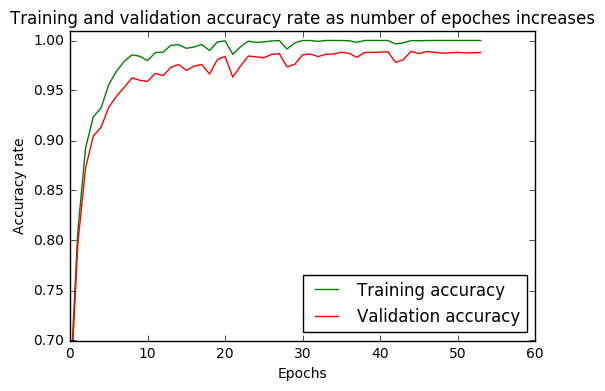

In [25]:
# plot training accuracy and validation set accuracy. 
epoch_length = range(len(epoch_valid))
plt.plot(epoch_length, epoch_train, 'g', label='Training accuracy')
plt.plot(epoch_length, epoch_valid, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy rate')
plt.ylim((0.7,1.01))
plt.title('Training and validation accuracy rate as number of epoches increases')
plt.legend(loc='lower right')
plt.show()

In [26]:
max_epoch = np.argmax(epoch_valid)
max_epoch_value = epoch_valid[max_epoch]
print('The highest Validation accracy rate is {0:>.2%} in epoch {1:>4}.'.format(max_epoch_value, max_epoch))

The highest Validation accracy rate is 98.92% in epoch   44.


Accuracy on Test-Set: 91.6% (11574 / 12630)
Example errors:
<class 'numpy.ndarray'>
images length is:  (9, 32, 32, 1)
cls_true length is:  (9,)
i:  0
ax:  Axes(0.125,0.684722;0.215278x0.215278)
i:  1
ax:  Axes(0.404861,0.684722;0.215278x0.215278)
i:  2
ax:  Axes(0.684722,0.684722;0.215278x0.215278)
i:  3
ax:  Axes(0.125,0.404861;0.215278x0.215278)
i:  4
ax:  Axes(0.404861,0.404861;0.215278x0.215278)
i:  5
ax:  Axes(0.684722,0.404861;0.215278x0.215278)
i:  6
ax:  Axes(0.125,0.125;0.215278x0.215278)
i:  7
ax:  Axes(0.404861,0.125;0.215278x0.215278)
i:  8
ax:  Axes(0.684722,0.125;0.215278x0.215278)


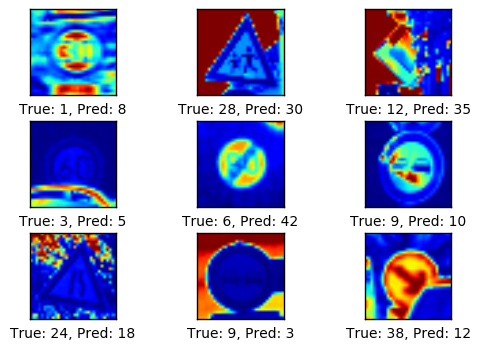

0.9163895486935867

In [27]:
# Check the test accuracy
print_test_accuracy(X_test_yuv, y_test, valid_set=False, show_example_errors=True)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

Type of model used: Convolutional neural network 

Structures: 
<img src='./structure.png' />

- Original image is grayscaled image with 32x32x1 shape


- Stage 1: Convolute 16 filter of size 5x5 with original image get C1(convolutional layer 1). Then convert C1 feature maps by max pooling/subsampling to get P1(max pooling feature maps 1). It is mainly for reduce its image size and reduce noise. Then do activation to P1 by ReLu, mainly for differentiable thresholding.  


- Stage 2: Convolute 36 filter of size 5x5 with original image get C2. Then convert C2 feature maps by max pooling/subsampling to get P2(max pooling feature maps 2). Then do activation to P2 by ReLu.


- Prepare input features for the following DNN by flat the 36@8*8*1 layer to a 1d feature vectors (2304 features in total).  


- Use a 128-neurals NN layer as a hidden layer to classify the 1d feature vectors, then a ReLu to give non-linear property


- Use a 43-neurals NN layer as a final classifier (43 label types in total)


- Softmax layer_fc2 to give probablity distribution

**Updates for submission 2 **

Reasons for choosing CNN:
- CNN is a special type of neural network. By using 2-layer neural network(include a non-linear activation between 2 layers), neural network theoretically can almost represent any type of functions to capture the hidden patterns in the dataset (2 layers can represent every functions but may need very large number of nodes in each layer if hidden patterns are complicated, therefore in reality we ofter add more layers and use less nodes in each layer). 

- Convolutional layer in the front of whole architecture can reduce noise and help to capture hidden patterns in input image. Therefore, each feature map in convolutional layer can capture a pattern in the orginal image. By applying lots of filter maps in a layer, the convolutional layer can capture different kind of patterns in the same image. Therefore, convolutional layer 1 can caputure some abstract structures in input image (such as lines, curves) and store each structure in a feature map. Convolutional layer 2 can abstract more complicated while meaningful structure from covolutional layer 1 (such as a rectangle, circle). So on and so forth, after lots of convolutional layers, the input image is represented by lots of highly structured patterns. Therefore we can use classifier (normal deep neural nets or other classifiers) to use the highly structured patterns (instead of original image pixel values) to do classification task.     

- Whole CNN architecture is differentiable, therefore, optimizer can use the predicted label and real label to adjust weights and bias in whole architecture to get better classification accuracy rate. 



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer type: AdamOptimizer

Training Batch size: 64 

Test batch size: 256

Epochs: 45

hyperparameters: Filter used: filter_1(size: 16@5x5x1, stride: 1 step, padding: 'same'), filter_2(size: 36@5x5x1, stride 1 step, padding: 'same'), pooling_1 (size: 2x2, stride: 2), pooling_2(size: 2x2, stride: 2)
hidden layer for DNN: 128 neurons, final classifier: 43 neurons

Methods:
- use AdamOptimizer as Optimizer to adjust parameters in all CNN layers (including all weights metrices, all bias metrics) to reduce cost function.
- cost function is by caculating entropies between predicted labels and real labels in each training batch. 

**Updates for submission 2**
- Train the model as shown in 'In [24]' (By using optimizer function while set epoch limit to a large number) to optimize output while preventing overfitting. 
- Method used in preventing overfitting: set the limited epoch value to be a very large value (In this case, 500 epochs), and record every validation accuracy after each epoch. Compare the last 10 validation accuracies after 11 epochs. If a validation accuracy rate is higher than its 10 newer ones, stop the optimization and output its epoch index. In this case, best epoch found is epoch 45 (validation accuracy in epoch 45 is higher than 10 newer ones from epoch 46 to epoch 55). By using this way, the model can prevent overfitting. 

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

- First explore the dataset knowing that labels are not shuffled and label number distribution is skewed

- Pre-processing: Convert into grayscale, shuffle the data and normalize.

- Define the basic graphic structure

- Define the cost function and optimizer

- Run training batches to auto adjusts all parameters in the graphic structure (including all weights and biases )

- Test on test set to get accuracy

- Based on the test set accuracy, adjust hyper-prameters and re-train the model to get better accuracy.

- repeat previous steps until get satisfied result

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [38]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
### Run the predictions here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg

def read_image(image_path):
    image = mpimg.imread(image_path).astype('uint8')
    return image

img_stack = np.zeros((1,32,32,1))
img_list = os.listdir('./data/image/')
img_list = sorted(img_list)
image_dir = './data/image/'
for image_name in img_list:
    print(image_name)
    image_path = image_dir + image_name
    if os.path.isdir(image_path):
        continue
    image = read_image(image_path)
    gray_imread = tf.image.rgb_to_grayscale(image)
    gray_imread = session.run(gray_imread)
    gray_imread = np.expand_dims(gray_imread, axis=0)
    print('gray_imread shape: ', gray_imread.shape)
    img_stack = np.concatenate((img_stack, gray_imread))
img_stack = img_stack[1:]

0_20_flip.jpg
gray_imread shape:  (1, 32, 32, 1)
13_yield.jpg
gray_imread shape:  (1, 32, 32, 1)
14_stop.jpg
gray_imread shape:  (1, 32, 32, 1)
15_no_vehicles.jpg
gray_imread shape:  (1, 32, 32, 1)
22_bumpy.jpg
gray_imread shape:  (1, 32, 32, 1)
2_50_limit.jpg
gray_imread shape:  (1, 32, 32, 1)
34_left_turn.jpg
gray_imread shape:  (1, 32, 32, 1)
3_60_limit.jpg
gray_imread shape:  (1, 32, 32, 1)
7_100_limit.jpg
gray_imread shape:  (1, 32, 32, 1)
8_120_limit.jpg
gray_imread shape:  (1, 32, 32, 1)
9_no_passing.jpg
gray_imread shape:  (1, 32, 32, 1)


In [39]:
output_label = session.run(y_pred_cls, feed_dict={x:img_stack})
true_label_ids = []
for i, j in zip(output_label, img_list):
    print('Pred output vs real output:  ', i, ' vs ', j)
    true_label_ids.append(j.split('_')[0])
# print(output_label)

# print how many of them are the same
int_true = [int(i) for i in true_label_ids]
int_true = np.array(int_true).astype(np.int64)
comparison = (int_true == output_label)
print('Accuracy rate is: ', 1. * sum(comparison)/len(comparison))
# print(type(output_label[0]))

Pred output vs real output:   0  vs  0_20_flip.jpg
Pred output vs real output:   13  vs  13_yield.jpg
Pred output vs real output:   14  vs  14_stop.jpg
Pred output vs real output:   12  vs  15_no_vehicles.jpg
Pred output vs real output:   22  vs  22_bumpy.jpg
Pred output vs real output:   2  vs  2_50_limit.jpg
Pred output vs real output:   20  vs  34_left_turn.jpg
Pred output vs real output:   0  vs  3_60_limit.jpg
Pred output vs real output:   0  vs  7_100_limit.jpg
Pred output vs real output:   6  vs  8_120_limit.jpg
Pred output vs real output:   9  vs  9_no_passing.jpg
Accuracy rate is:  0.545454545455


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

<img src='./pred.png' />

(Please note: All new test image are named based on TrueLabel_LabelMeaning.jpg format)

- The above candidate images are plotted in below cell. All New images are downloaded from internet. 

- 0_20_flip.jpg is predicted as 33(True right ahead). The reason behind is possible the picture is taken a bit sliding. But 14_stop.jpg is also sliding, and its prediction is correct.

- 22_bumpy.jpg is predicted as 31, which is 'Wild animals crossing' sign. Comparing to wild animal crossing sign in Germany, it is quite similar. The difference is just inside the triangle, the line in bumpy.jpg is a horizontal line, while wild animal crossing is like a inclined line. Therefore, it seems a reasonable error. 

- Both 3_60_limit.jpg and 7_100_limit.jpg are predicted as 2: 50_limit.jpg. The structure in those images are quite similar, just one number is different. 

In [40]:
def plot_images_2(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=2, wspace=2)

    for i, ax in enumerate(axes.flat):
        print('i: ', i)
        print('ax: ', ax)
        # ax.imshow(images[i], cmap='binary')
        ax.imshow(np.squeeze(images[i], axis=(2, )))
        if cls_pred is None:
            xlabel = "T: {0}".format(cls_true[i])
        else:
            xlabel = "T: {0}, P: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

i:  0
ax:  Axes(0.125,0.789286;0.110714x0.110714)
i:  1
ax:  Axes(0.457143,0.789286;0.110714x0.110714)
i:  2
ax:  Axes(0.789286,0.789286;0.110714x0.110714)
i:  3
ax:  Axes(0.125,0.457143;0.110714x0.110714)
i:  4
ax:  Axes(0.457143,0.457143;0.110714x0.110714)
i:  5
ax:  Axes(0.789286,0.457143;0.110714x0.110714)
i:  6
ax:  Axes(0.125,0.125;0.110714x0.110714)
i:  7
ax:  Axes(0.457143,0.125;0.110714x0.110714)
i:  8
ax:  Axes(0.789286,0.125;0.110714x0.110714)


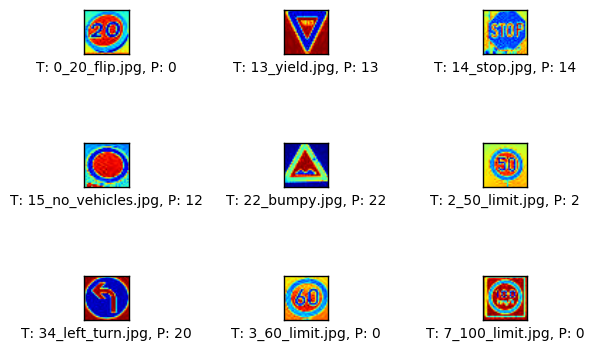

In [41]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# plot all chosen image 
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = X_test_yuv[incorrect]

    cls_pred = cls_pred[incorrect]

    cls_true = y_test[incorrect]

    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

plot_images_2(images=img_stack[0:9], cls_true=img_list[0:9], cls_pred=output_label[0:9])

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

No. Its performance is clearly worth(55% out of 10 images comparing to 90% in the testing set). I think the reason may be 
- What I used in new test image is not traffic sign from Germany.
- Same traffic sign can have multiple formats, such as squared stop sign and round stop sign, the new test images are in a different format comparing to same type of images in training, testing set. 
- The angle is not so fit comparing to original testing set (Extracted from videos). Building jittered data set from the training data can help with this problem to improve performance.

In [81]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

output_top_k = tf.nn.top_k(y_pred, k=5)
prob_metrices, prob_labels = session.run(output_top_k, feed_dict={x:img_stack})

print(prob_metrices)
print(prob_labels)

[[  1.00000000e+00   4.70588082e-11   1.11792589e-11   2.53406909e-12
    2.13520694e-12]
 [  1.00000000e+00   7.78563333e-38   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  9.99954343e-01   4.57085589e-05   1.70626168e-13   3.03666500e-15
    2.27391971e-18]
 [  5.24231076e-01   4.75768983e-01   3.03921233e-12   2.21012214e-13
    2.18645648e-14]
 [  6.95706367e-01   3.04285437e-01   8.24414565e-06   1.04182005e-08
    6.30222763e-09]
 [  1.00000000e+00   2.59071210e-19   2.20133239e-22   3.09959170e-32
    5.97212603e-35]
 [  1.00000000e+00   6.74738670e-18   3.35793889e-21   7.94743283e-23
    2.89927140e-25]
 [  1.00000000e+00   4.16513386e-11   2.84303961e-12   2.62835509e-15
    3.98146278e-22]
 [  1.00000000e+00   4.85551432e-10   5.09786250e-17   2.37580499e-17
    5.94826972e-22]
 [  9.99808609e-01   1.91402651e-04   2.04746081e-10   8.84256251e-14
    2.11519839e-15]
 [  1.00000000e+00   3.90905440e-17   3.69922366e-18   8.97477420e-19
    3.87912120e-25]]
[[33  1 1

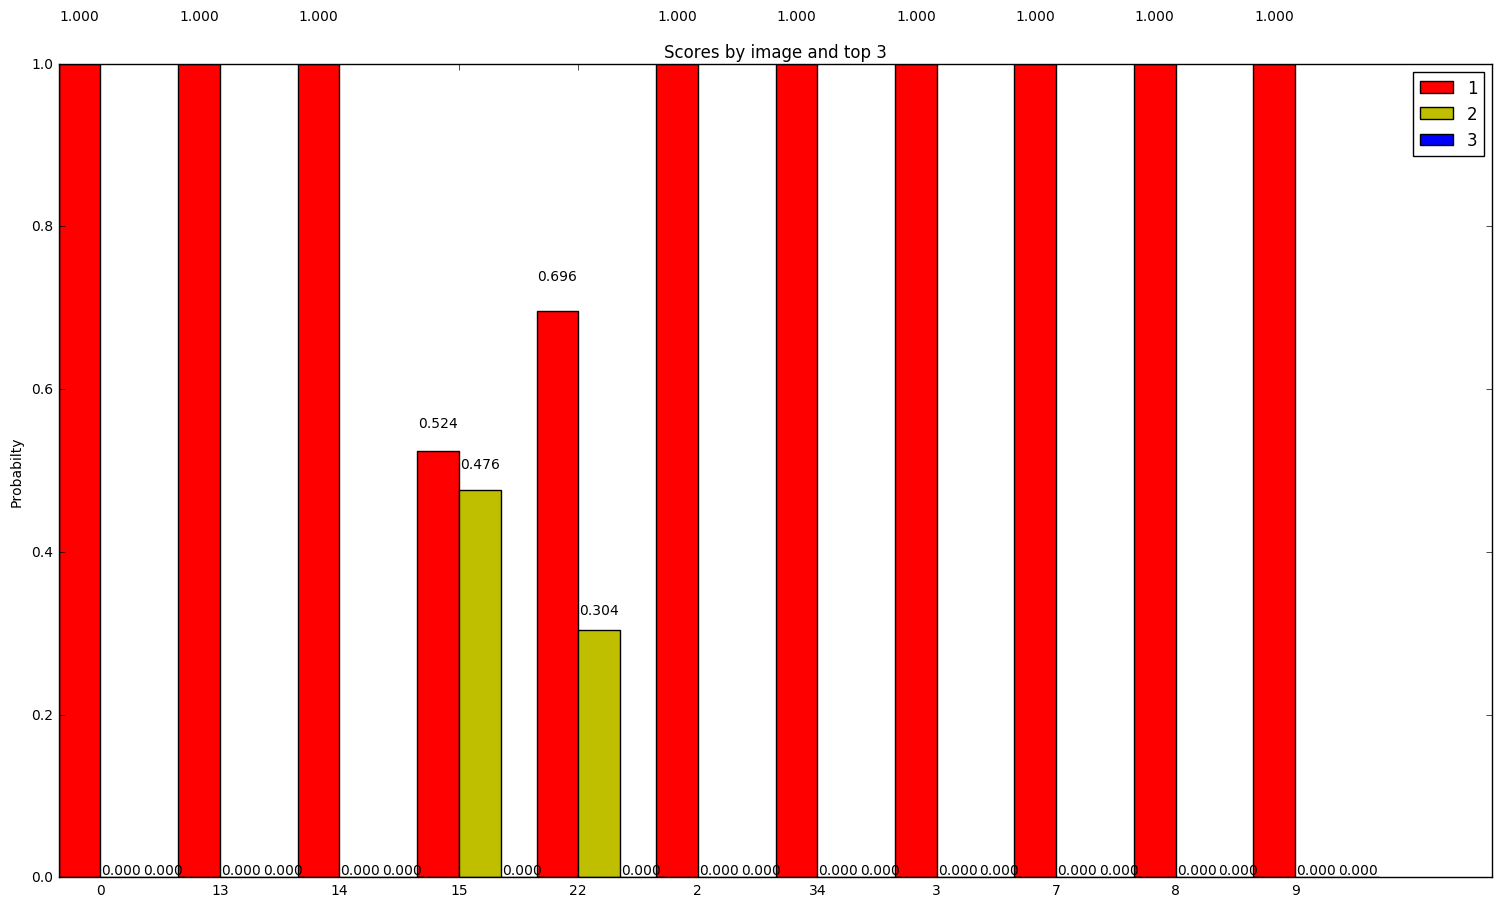

In [82]:
N = len(prob_labels)

top = prob_metrices[:, 0]

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)

rects1 = ax.bar(ind, top, width, color='r')

top_2 = prob_metrices[:, 1]
rects2 = ax.bar(ind + width, top_2, width, color='y')

top_3 = prob_metrices[:, 2]
rects3 = ax.bar(ind + 2 * width, top_3, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Probabilty')
ax.set_title('Scores by image and top 3')
ax.set_xticks(ind + width)
ax.set_xticklabels(true_label_ids)

ax.legend((rects1[0], rects2[0], rects3[0]), ('1', '2', '3'))


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % float(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

(Please note: All new test image are named based on TrueLabel_LabelMeaning.jpg format)

- Based on the graph above, there are only 2 pictures the model does not certain. They are 15_no_vehicles.jpg(First prediction is correct) and 22_bumpy.jpg(second prediction is correct). 

- 22_bumpy.jpg, the CNN top prediction is 31, which is wrong, but its second prediction is 22, and it has 0.304 probability. 

- 15_no_vehicles's top prediction is right as the real label, even though its top 2 are almost tie. 

**Updates for submission 2**
<img src='./predict_matrix.png' \>
**Canptured in 'In [81]' output
The upper matrix is softmax probablities, and lower matrix is one hot encoding for each new test images. And the real label sequence for images above is [0, 13, 14, 15, 22, 2, 34, 3, 7, 8, 9] **
- Based on the image above, by using tf.nn.top_k(k=5), there are other 3 new images are classified correctly, they are 22_bunpy.jpg(prediction no. 2), 3_60_limit.jpg(prediction no. 2) and 7_100_limit.jpg(prediction no. 2), then there will be 9 out of 11 are classified correctly.  

- But the true label of 0_20_flip.jpg and 8_120_limit.jpg are also not included in its top 5 prediction. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

The model built currently cannot be exported due to time limitation. It can only be run from the top to train a new model up to now. The feature will be added in its next version. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

Disclosure: I used and revised some code from CarND_TensorFlow_Lab repository (https://github.com/udacity/CarND-TensorFlow-Lab) and Hvass-Labs/TensorFlow-Tutorials repo (https://github.com/Hvass-Labs/TensorFlow-Tutorials under MIT license). Please be noted. 